In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Synthesis of Ultra Wide Band Waveforms

Once the propagation channel has been evaluated. This is done in the `pylayers.antprop.channel` module. 
The received signal is evaluated in applying a convolution product of each ray tranfer function with a specific
IR-UWB waveform. The necessary modules are 

+ `pylayers.signal.bsignal`.
+ `pylayers.signal.waveform`
+ `pylayers.signal.channel`

The module `pylayers.simul.simulem` is for definition of electromagnetic simulation.  

In [3]:
from pylayers.signal.bsignal import *
from pylayers.signal.waveform import *
from pylayers.antprop.channel import *
from pylayers.simul.simulem import *

### Generation of an Impulse of normalized energy 

One possible manner to define an energy normalized short UWB impulse is as follows using  `bsignal.EnImpulse` function. 

The default waveform is a gaussian windowing of a sine wave of frequency $f_c$. The normalization term depends on the exponential scaling factor $\tau$. 

$p(t)= \frac{\sqrt{2\sqrt{2}}}{\tau\sqrt{\pi}} \cos(2\pi f_c t) e^{-(\frac{t}{\tau})^2}$

$\tau = \frac{2}{B\pi}\sqrt{\frac{\gamma_{dB}\ln{10}}{20}}$

where $B$ is the desired bandwidth defined at $\gamma_{dB}$ below the spectrum maximum and $f_c$ is the central frequency of the pulse.




In [4]:
fc     = 4 
band   = 2
thresh = 10
fe     = 100 
ip     = EnImpulse([],fc,band,thresh,fe)

In [5]:
ip.info()

TUsignal
--------
shx :  (343,)
shy :  (343,)
dx :   0.01
xmin : -1.71
xmax : 1.71
ymin : -1.89545539648
ymax : 2.16154131873


## Verification of energy normalization in both domains

In [6]:
E1= sum(ip.y*ip.y)*ip.dx()
print "Integration in time",E1

Integration in time 1.0


In [7]:
P = ip.esd()
E2 = sum(P.y)*P.dx()
print "Integration in frequency domain ",E2

Integration in frequency domain  1.0


## Calculation of UWB channel impulse response

We choose to load a simple floor plan. 

In [8]:
S = Simul()
S.L = Layout('defstr3.ini')

A simulation object has an `info` method providing a summary of simulation informations.

In [9]:
st = S.wav.st
sf = S.wav.sf
S.wav.info()

fcGHz  :  4.493
typ  :  generic
feGHz  :  100
Np  :  3000
twns  :  30
te  :  0.01
threshdB  :  3
bandGHz  :  0.499


The waveform associated with the simulation object is 

In [10]:
S.wav

{'Np': 3000,
 'bandGHz': 0.499,
 'fcGHz': 4.493,
 'feGHz': 100,
 'te': 0.01,
 'threshdB': 3,
 'twns': 30,
 'typ': 'generic'}

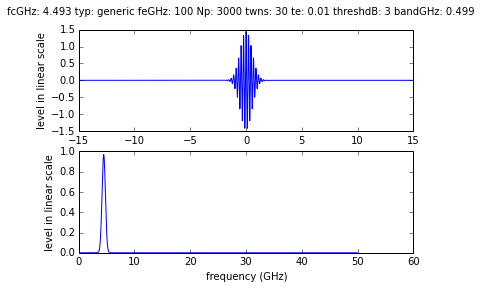

In [11]:
S.wav.show()

Above the waveform is a generic UWB waveform. The interested user can add easyly any other mathematical expression of UWB waveform for investigation on pulse waveform modulation for example. The waveform can also comes from measurement. For now there are two version of this waveform which has been used during the M1 measurement campaign. One is not compensated `W1compensate` for an extra short delay which can introduse a bias when interpretating the observed delay in terms of distance. The non compensated version is `W1offset` from the time origin about 0.7 ns.

The waveform class should grow for incorporating more waveforms, especially waveforms compliants with the current IEEE 802.15.4a and IEEE 802.15.6 standards. 

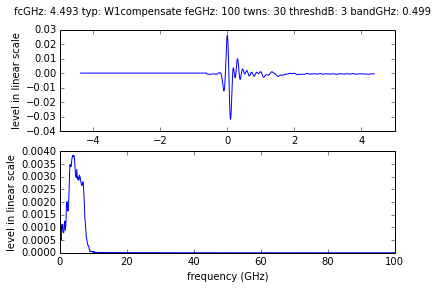

In [12]:
wavmeasured = Waveform(typ='W1compensate')
wavmeasured.show()

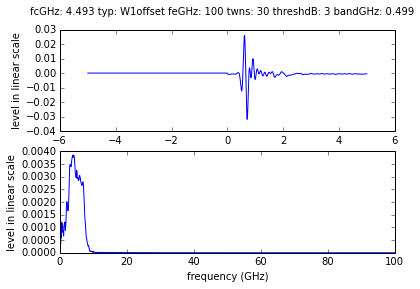

In [13]:
wavmeasured = Waveform(typ='W1offset')
wavmeasured.show()

Here the time domain waveform is measured and the anticausal part of the signal is artificially set to 0.

To handle properly the time domain wavefom in PyLayers, it is required to center the signal in the middle of the array.  The waveform has embedded in the object its frequency domain and time domain representation.  

+ `st` member stands for signal in time domain
+ `sf` member stands for signal in frequency domain

In [14]:
print type(S.wav.sf)
print type(S.wav.st)

<class 'pylayers.signal.bsignal.FUsignal'>
<class 'pylayers.signal.bsignal.EnImpulse'>


+ `FUsignal` Frequency domain uniformly sampled base signal 
+ `TUsignal` Time domain uniformly sampled base signal

## Construction of the propagation channel 

The following representation shows the spatial spreading of the propagation channel. 
On the left are scattered the intensity of rays wrt to angles of departure (in azimut and elevation). 
On the right is the intensity of rays wrt to angles of arrival. It misses the application between the 2
planes as well as the delay dimension of the propagation channel.

In [15]:
from pylayers.antprop.signature import *
from pylayers.antprop.channel import *

In [16]:
S.L.build()

In [17]:
S.L


----------------
defstr3.ini
Image('/home/uguen/Bureau/P1/struc/images/TA-Office.png')
----------------

Number of points  : 8
Number of segments  : 9
Number of sub segments  : 3
Number of cycles  : 3
Number of rooms  : 2
degree 0 : []
degree 1 : [-8 -7]
degree 2 : 4
degree 3 : 2

xrange :(758.49, 768.516)
yrange :(1111.9, 1115.963)

Useful dictionnaries
----------------
dca {cycle : []} cycle with an airwall
sl {slab name : slab dictionary}
name :  {slab :seglist} 

Useful arrays
----------------
pt : numpy array of points 
normal : numpy array of normal 
offset : numpy array of offset 
tsg : get segment index in Gs from tahe
isss :  sub-segment index above Nsmax
tgs : get segment index in tahe from Gs
lsss : list of segments with sub-segment
sla : list of all slab names (Nsmax+Nss+1)
degree : degree of nodes 

In [18]:
S.L.Gt.pos

{0: (758.49, 1111.9),
 1: (766.00300113353387, 1113.947479109665),
 2: (761.00289669547806, 1113.915769812613)}

In [19]:
tx=np.array([759,1114,1.0])
rx=np.array([767,1114,1.5])
ctx = S.L.pt2cy(tx)
crx = S.L.pt2cy(rx)

The sequence of command below :
    
+ initialize a signature between cycle ctx and cycle crx
+ evaluates the signature with a given cutoff value
+ calculates a set of 2D rays from signature and tx/rx coordinates
+ calculates a set of 3D ray from 2D rays and layout and ceil height (default H=3m)
+ calculates local basis and various geometric information out of the 3D ray and Layout 
+ fill and reorganize the interactions object with proper material chararcteristics

In [20]:
Si = Signatures(S.L,ctx,crx)
Si.run5(cutoff=5)
r2d = Si.rays(tx,rx)
r3d = r2d.to3D(S.L)
r3d.locbas(S.L)
r3d.fillinter(S.L)

Define a frequency base in GHz.

In [21]:
fGHz = np.arange(2,10,0.01)

Evaluate the propagation channel $\tilde{\mathbf{C}}$. Here the meaning of tilde is that the complex value of the channel do not include the phase term due to delay along the ray. 

In [22]:
C = r3d.eval(fGHz) 

##  Construction of the transmission channel

The transmission channel is obtained from the combination of the propagation channel $\tilde{\mathbf{C}}$ and the vector antenna pattern at both side of the radio link. This operation is implemented in the `prop2tran` method of the `Ctilde` class.  

In [23]:
sc = C.prop2tran()

The transmission channel is obtained by applying a vector radiation pattern using an antenna file.

In the presented case, it comes from a real antenna which has been used during the **FP7 project WHERE1** measurement campaign 
M1.

In [24]:
sc

freq :2.0 9.99 800
shape  :(345, 800)
tau :26.7186992365 99.5048504397
dist :8.01560977094 29.8514551319
Friis factor -j c/(4 pi f) has been applied

The antenna radiation pattern is stored in a very compact way thanks to Vector Spherical Harmonics decomposition.
The following gives information about the content of the antenna object.

In [25]:
S.tx.A.info()

defant.vsh3
type :  vsh
No vsh coefficient calculated yet


The figure below plot on a same graph all the tansfer function in modulus and phase of the ray transfer function.

If a realistic antenna is applied it gives 

In [26]:
sca = C.prop2tran(S.tx.A,S.rx.A)

## Calculate UWB Channel Impulse Response 

Once the transmission channel has been evaluated on can convolved the waveform with the channel impulse response to get the received waveform.

In [27]:
r = sca.applywavB(S.wav.sfg)

In [28]:
r.y

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
        -1.24043824e-13,   8.30460833e-14,   2.32608932e-14])

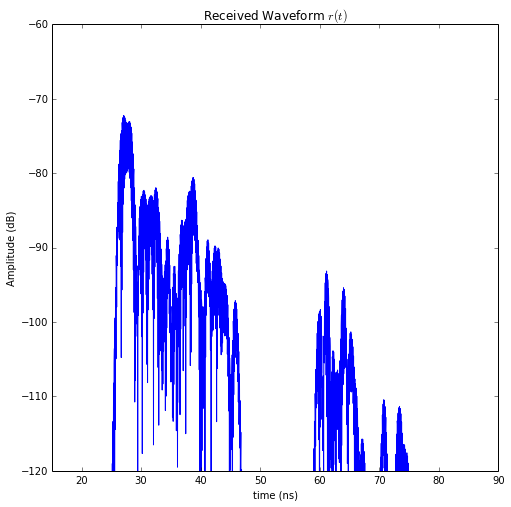

In [29]:
fig,ax = r.plot(typ=['l20'])
plt.axis([15,90,-120,-60])
plt.title(u'Received Waveform $r(t)$')

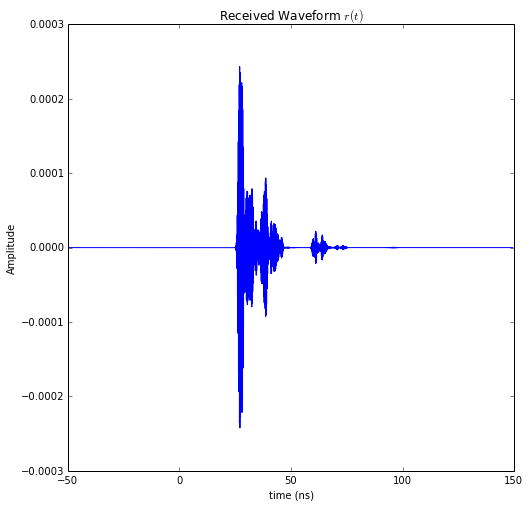

In [30]:
r.plot(typ=['v'])
#plt.axis([15,60,-0.3,0.3])
plt.title(u'Received Waveform $r(t)$')

## Hermitian symetry enforcment 

If the number of point for the transmission channel and the waveform were the same the mathematical operation is an Hadamrd-Shur product between 
$\mathbf{Y}$ and $\mathbf{W}$. 

$\mathbf{Y} = \mathbf{S} \odot \mathbf{W}$

In practice this is what is done after a resampling of the time base with a reinterpolated  time step. 

The process which consists in going from time domain to frequency domain is delegated to a specialized class `pylayers.signal.bsignal.Bsignal` which maintains the proper 
binding between signal samples and their indexation either in time or in frequency domain.

In [31]:
wgam = S.wav.sfg
Y    = sc.apply(wgam)
tau  = Y.taud
dod = Y.dod
doa = Y.doa

The transmission channel has a member data which is the time delay of each path in nano seconds. Notice that by default those delay are not sorted. 

In [32]:
print 'tau =', tau[0:20]

tau = [ 26.71869924  27.93842436  29.10708199  29.64889324  30.03048589
  30.075433    36.72255959  30.75261837  31.12068041  31.1640552
  31.81807982  32.17395555  32.21591227  32.36081306  32.66533294
  33.05244038  34.35921355  37.6193175   37.62655033  37.86521462]


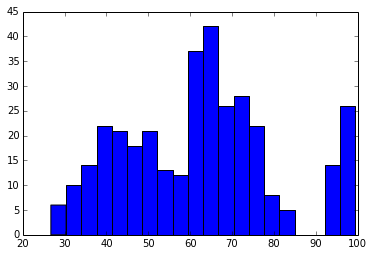

In [33]:
h = plt.hist(tau,20)

Direction of arrival $(\theta_r,\phi_r)$ in radians

In [34]:
print "doa = ", doa[1:10,:]

doa =  [[ 1.8736812  -3.14159265]
 [ 1.15838589 -3.14159265]
 [ 1.62703943  2.69865609]
 [ 1.62632401 -3.14087348]
 [ 1.62624094 -2.65738656]
 [ 1.61619728  0.01122758]
 [ 1.84520693  2.69865609]
 [ 1.84187905 -3.14087348]
 [ 1.84149225 -2.65738656]]


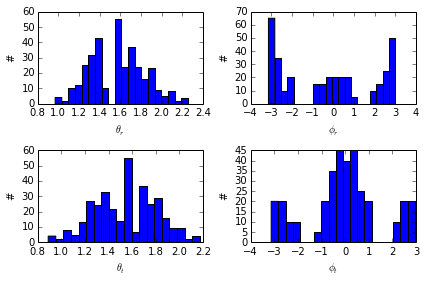

In [35]:
plt.subplot(221)
ht = plt.hist(doa[:,0],20)
plt.xlabel(u'$\\theta_r$')
plt.ylabel('#')
plt.subplot(222)
hp = plt.hist(doa[:,1],20)
plt.xlabel(u'$\phi_r$')
plt.ylabel('#')
plt.subplot(223)
ht = plt.hist(dod[:,0],20)
plt.xlabel(u'$\\theta_t$')
plt.ylabel('#')
plt.subplot(224)
hp = plt.hist(dod[:,1],20)
plt.xlabel(u'$\phi_t$')
plt.ylabel('#')
plt.tight_layout()